In [1]:
%cd ..

/home/sasha/effective-inference


## Modules

In [2]:
from typing import Tuple, List, Dict, Optional, Union
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from datasets.dataset_dict import DatasetDict

from utils.prepare_dataset import load_datasets, cut_datasets
from utils.attention_patterns.bert_module_linear import LinearClassifierBertAttention, BertWrapperLin
# from utils.attention_patterns.gpt2_module_linear import 

In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import torch
#from progressbar import progressbar
from tqdm.auto import tqdm
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
from transformers.models.bert.modeling_bert import BertSelfAttention, BertModel, BaseModelOutputWithPastAndCrossAttentions
from typing import Optional, Tuple, Union, List
from torch import nn
from copy import deepcopy
import joblib


WINDOW_SIZE = 10

class LinearClassifierBertAttention(BertSelfAttention):
    """
    Idea: attention weights are predicted by Linear Classifier
    """
    def set_models(self, coefs, layer):
        # print(coefs.size)
        # print(coefs[768])
        self.hidden_pred = torch.nn.Linear(
            in_features=768,
            out_features=1
        )
        self.hidden_pred.data = torch.tensor(coefs[:768]).view(1, -1).to(DEVICE)
        self.pos_i_coef = coefs[768]
        self.pos_j_coef = coefs[769]
        self.relev_pos_i_coef = coefs[770]
        self.relev_pos_j_coef = coefs[771]
        self.inv_pos_i_coef = coefs[772]
        self.inv_pos_j_coef = coefs[773]
        self.inv_relev_pos_i_coef = coefs[774]
        self.inv_relev_pos_j_coef = coefs[775]
        self.seq_len_coef = coefs[776]
        self.inv_seq_len_coef = coefs[777]
        self.layer_coef = coefs[778]
        self.layer = layer

    def set_window_size(self, window_size):
        self.WINDOW_SIZE = window_size

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
        special_tokens_idxs: Optional[List[int]] = [0]
    ) -> Tuple[torch.Tensor]:
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
            special_tokens_idxs = (encoder_hidden_states[0] < 103).nonzero().squeeze()
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
            special_tokens_idxs = (encoder_hidden_states[0] < 103).nonzero().squeeze()
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:

            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
    
        seq_len = hidden_states.shape[1]
        hidden_states_attention_features = self.hidden_pred(hidden_states)
        

        predicted_attention = hidden_states_attention_features.repeat(1, 1, seq_len) #.transpose(1, 2) # bs, seq_len, 1        
        positions = torch.arange(seq_len)

        # add i, j pos features
        positions_features_from = positions * self.pos_i_coef # seq_len
        positions_features_out = positions * self.pos_j_coef # seq_len
        predicted_attention += positions_features_from.T
        predicted_attention += positions_features_out

        # add relev i, j pos features
        relev_positions_features_from = (seq_len - positions) * self.relev_pos_i_coef # seq_len
        relev_positions_features_out = (seq_len - positions) * self.relev_pos_j_coef # seq_len
        predicted_attention += relev_positions_features_from.T
        predicted_attention += relev_positions_features_out
       

        inv_positions_features_from = (positions / seq_len) * self.inv_pos_i_coef # seq_len
        inv_positions_features_out = (positions / seq_len) * self.inv_pos_j_coef # seq_len
        predicted_attention += inv_positions_features_from.T
        predicted_attention += inv_positions_features_out
        
        
        inv_relev_positions_features_from = ((seq_len - positions) / seq_len) * self.inv_relev_pos_i_coef # seq_len
        inv_relev_positions_features_out = ((seq_len - positions) / seq_len) * self.inv_relev_pos_j_coef # seq_len
        predicted_attention += inv_relev_positions_features_from.T
        predicted_attention += inv_relev_positions_features_out

        seq_len_feature = self.seq_len_coef * seq_len # 1
        inv_seq_len_feature = self.inv_seq_len_coef * (1 / seq_len) # 1
        layer_feature = self.layer * self.layer_coef # 1
        predicted_attention += seq_len_feature
        predicted_attention += inv_seq_len_feature
        predicted_attention += layer_feature
        
        predicted_attention = torch.clamp(predicted_attention, min=-10, max=10)
        # print(predicted_attention)
        attention_probs = torch.exp(predicted_attention) #torch.nn.functional.softmax(predicted_attention, dim=-1)
        # print(attention_probs)
        # print(value_layer.squeeze(1).size())
        context_layer = torch.matmul(attention_probs, value_layer.squeeze(1))
        # print(context_layer.size())
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

    
        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs


class BertWrapperLin(nn.Module):
    def __init__(self, model, new_attention_class, final_model_weights_dict,  layer_nums=None, window_size=2):
        super().__init__()

        self.bert_model = deepcopy(model)
        self.layer_nums = layer_nums
        self.final_model_weights_dict = final_model_weights_dict


        # Create a list of modules to modify
        modules_to_modify = []
        for i in final_model_weights_dict.keys():
            if (layer_nums is not None and i in layer_nums) or (layer_nums is None):
                mean_attention = new_attention_class(self.bert_model.config)
                mean_attention.set_window_size(window_size)
                mean_attention.load_state_dict(self.bert_model.encoder.layer[i].attention.self.state_dict())
                # mean_attention.encoder_hidden_states = self.bert_model.encoder.layer[i].attention.self.encoder_hidden_states
                if self.final_model_weights_dict is not None: # and i in final_model_weights_dict.keys():
                    mean_attention.set_models(self.final_model_weights_dict[i], i)
                self.bert_model.encoder.layer[i].attention.self = mean_attention

    def forward(self, *args, **kwargs):
        return self.bert_model(*args, **kwargs)

In [4]:
from transformers import Conv1D
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention, GPT2Model
import math
import os
import warnings
from dataclasses import dataclass
from typing import Optional, Tuple, Union
from copy import deepcopy

import torch
import torch.utils.checkpoint
from torch import nn
from torch.cuda.amp import autocast
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from transformers.pytorch_utils import prune_conv1d_layer, find_pruneable_heads_and_indices

WINDOW_SIZE = 5
    
class LinearClassifierGPT2Attention(GPT2Attention):

    def set_models(self, coefs, layer):
        # print(coefs.size)
        # print(coefs[768])
        self.hidden_pred = torch.nn.Linear(
            in_features=768,
            out_features=1
        )
        self.hidden_pred.data = torch.tensor(coefs[:768]).view(1, -1).to(DEVICE)
        self.pos_i_coef = coefs[768]
        self.pos_j_coef = coefs[769]
        self.relev_pos_i_coef = coefs[770]
        self.relev_pos_j_coef = coefs[771]
        self.inv_pos_i_coef = coefs[772]
        self.inv_pos_j_coef = coefs[773]
        self.inv_relev_pos_i_coef = coefs[774]
        self.inv_relev_pos_j_coef = coefs[775]
        self.seq_len_coef = coefs[776]
        self.inv_seq_len_coef = coefs[777]
        self.layer_coef = coefs[778]
        self.layer = layer

    def set_window_size(self, window_size):
        self.WINDOW_SIZE = window_size
    def forward(
            self,
            hidden_states: Optional[Tuple[torch.FloatTensor]],
            layer_past: Optional[Tuple[torch.Tensor]] = None,
            attention_mask: Optional[torch.FloatTensor] = None, 
            head_mask: Optional[torch.FloatTensor] = None,
            encoder_hidden_states: Optional[torch.Tensor] = None,
            encoder_attention_mask: Optional[torch.FloatTensor] = None,
            use_cache: Optional[bool] = False,
            output_attentions: Optional[bool] = False) -> Tuple[Union[torch.Tensor, Tuple[torch.Tensor]], ...]:

        if encoder_hidden_states is not None:
            if not hasattr(self, "q_attn"):
                raise ValueError(
                    "If class is used as cross attention, the weights `q_attn` have to be defined. "
                    "Please make sure to instantiate class with `GPT2Attention(..., is_cross_attention=True)`."
                )

            query = self.q_attn(hidden_states)
            key, value = self.c_attn(encoder_hidden_states).split(self.split_size, dim=2)
            attention_mask = encoder_attention_mask
        else:
            query, key, value = self.c_attn(hidden_states).split(self.split_size, dim=2)

        seq_len = hidden_states.shape[1]
        hidden_states_attention_features = self.hidden_pred(hidden_states)
        
        predicted_attention = hidden_states_attention_features.repeat(1, 1, seq_len) # bs, seq_len, 1
        positions = torch.arange(seq_len)

        #special tokens
        # special_tokens_idxs = (encoder_hidden_states[0] < 103).nonzero().squeeze()
        
        # add i, j pos features
        positions_features_from = positions * self.pos_i_coef # seq_len
        positions_features_out = positions * self.pos_j_coef # seq_len
        predicted_attention += positions_features_from.T
        predicted_attention += positions_features_out
        
        # add relev i, j pos features
        relev_positions_features_from = (seq_len - positions) * self.relev_pos_i_coef # seq_len
        relev_positions_features_out = (seq_len - positions) * self.relev_pos_j_coef # seq_len
        predicted_attention += relev_positions_features_from.T
        predicted_attention += relev_positions_features_out
        
        inv_positions_features_from = (positions / seq_len) * self.inv_pos_i_coef # seq_len
        inv_positions_features_out = (positions / seq_len) * self.inv_pos_j_coef # seq_len
        predicted_attention += inv_positions_features_from.T
        predicted_attention += inv_positions_features_out
        
        inv_relev_positions_features_from = ((seq_len - positions) / seq_len) * self.inv_relev_pos_i_coef # seq_len
        inv_relev_positions_features_out = ((seq_len - positions) / seq_len) * self.inv_relev_pos_j_coef # seq_len
        predicted_attention += inv_relev_positions_features_from.T
        predicted_attention += inv_relev_positions_features_out

        
        seq_len_feature = self.seq_len_coef * seq_len # 1
        inv_seq_len_feature = self.inv_seq_len_coef * (1 / seq_len) # 1
        layer_feature = self.layer * self.layer_coef # 1
        predicted_attention += seq_len_feature
        predicted_attention += inv_seq_len_feature
        predicted_attention += layer_feature

        attention_probs = torch.exp(predicted_attention) #torch.nn.functional.softmax(predicted_attention, dim=-1)
        # print(value_layer.squeeze(1).size())
        context_layer = torch.matmul(attention_probs, value.squeeze(1))
        print(attention_probs.size())
        print(value.squeeze(1).size())
        context_layer = context_layer.permute(0, 2, 1).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)
        
        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        return outputs
    


class GPT2WrapperLin(nn.Module):
    def __init__(self, model, new_attention_class, final_model_weights, layer_nums=None, window_size=2):
        super().__init__()

        self.gpt2_model = deepcopy(model)
        self.layer_nums = layer_nums
        self.final_model_weights_dict = final_model_weights


        # Create a list of modules to modify
        modules_to_modify = []

        for i in layer_nums:
            if (layer_nums is not None and i in layer_nums) or (layer_nums is None):
                mean_attention = new_attention_class(self.gpt2_model.config)
                mean_attention.set_window_size(window_size)
                mean_attention.load_state_dict(self.gpt2_model.h[i].attn.state_dict())
                if self.final_model_weights_dict is not None: # and i in final_model_weights_dict.keys():
                    mean_attention.set_models(self.final_model_weights_dict[i], i)
                self.gpt2_model.h[i].attn = mean_attention
           
            

    def forward(self, *args, **kwargs):
        return self.gpt2_model(*args, **kwargs)


## Pipeline

In [4]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import torch
#from progressbar import progressbar
from tqdm.auto import tqdm

from collections import defaultdict

import seaborn as sns
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
import numpy as np
import json
import h5py
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

### Define Parameters

In [5]:
# Define dataset
dataset = {'sst2': ['sentence']}

# Define model (bert or gpt2)
model = 'bert' 
# model = 'gpt2' 

### Load Data

In [10]:
if model == 'bert':
    model_name = 'bert-base-uncased'
elif model == 'gpt2':
    model_name = 'gpt2'
else: model_name = 'bert-base-uncased'

DEBUG_FLAG = True
CUT_SIZE = None if not DEBUG_FLAG else 200

try:
    dataset_name = list(glue_classification.keys())[0]
    datasets = load_datasets('glue', list(dataset), CUT_SIZE)
except:
    dataset = {'mrpc': ['sentence1', 'sentence2']}
    dataset_name = 'mrpc'
    datasets = load_datasets('glue', list(dataset), CUT_SIZE)
    
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=1024)
initial_model = AutoModel.from_pretrained(model_name)
initial_model.eval()

# Define the device
device = 'cpu'#torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
DEVICE=device
initial_model.to(device)

None

In [11]:
for ex_idx, ex in tqdm(enumerate(datasets[dataset_name]['train'])):
    
    encoded_inputs = tokenizer.encode(
                    *[ex[i] for i in list(dataset.values())[0]],
                    truncation=True,
                    return_tensors='pt'
                ).to(device)
    aa = initial_model(encoded_inputs, output_hidden_states=True, output_attentions=True)

    for layer in  range(12):
        if not os.path.exists(f'notebooks/{dataset_name}/layer_{layer}'):
            os.makedirs(f'notebooks/{dataset_name}/layer_{layer}')

        for head_num in range(12): #range(aa.attentions[0].shape[1]):
            if not os.path.exists(f'notebooks/{dataset_name}/layer_{layer}/head_{head_num}'):
                os.makedirs(f'notebooks/{dataset_name}/layer_{layer}/head_{head_num}')

            current_hidden_states = aa.hidden_states[layer][0].detach().cpu().numpy()
            next_hidden_states = aa.hidden_states[layer + 1][0].detach().cpu().numpy()
            attentions = aa.attentions[layer][0][head_num].detach().cpu().numpy() # .item()

            cur_emb = aa.hidden_states[layer][0]

            with h5py.File(f'notebooks/{dataset_name}/layer_{layer}/head_{head_num}/{ex_idx}.hdf5', 'w') as f:
                f.create_dataset("current_hidden_states", data=current_hidden_states)
                f.create_dataset("next_hidden_states", data=next_hidden_states)
                f.create_dataset("attentions", data=attentions)

52it [00:10,  5.00it/s]


KeyboardInterrupt: 

In [20]:
datasets[dataset_name]['train'][:5]

[{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
  'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
  'label': 1,
  'idx': 0},
 {'sentence1': "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .",
  'sentence2': "Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .",
  'label': 0,
  'idx': 1},
 {'sentence1': 'They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .',
  'sentence2': "On June 10 , the ship 's owners had published an advertisement on the Internet , offering the explosives for sale .",
  'label': 1,
  'idx': 2},
 {'sentence1': 'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .',
  'sentence2': 'Tab shares jumped 20 cent

In [21]:
def get_dataset_for_regression(prob_of_take=0.01, layer=0, head_num=0):
    X_train, y_train = [], []
    X_test, y_test = [], []
    for ex_idx, ex in tqdm(enumerate(datasets[dataset_name]['train'][:100])):
        if np.random.choice([0, 1], size=1, p=[0.8, 0.2])[0] > 0.2:
            encoded_inputs = tokenizer.encode(
                                        *[ex[i] for i in list(dataset.values())[0]],
                                        truncation=True,
                                        return_tensors='pt'
                                    )
            # special_symbols = (encoded_inputs[0] < 103).nonzero().squeeze()
            for head_num in range(12):
                with h5py.File(f'notebooks/{dataset_name}/layer_{layer}/head_{head_num}/{ex_idx}.hdf5', 'r') as f:
        
                    current_hidden_states = f['current_hidden_states'][()]
                    next_hidden_states = f['next_hidden_states'][()]
                    attentions = f['attentions'][()]
            
                    len_of_seq = attentions.shape[0]
                    for from_ in range(len_of_seq):
                        for to_ in range(len_of_seq):
                            if np.random.choice([0, 1], size=1, p=[1-prob_of_take, prob_of_take])[0] > 0.2:
                                            #feature_vector = []
                                            # (pos form, pos to, is_from_special_token, is_to_special_token,
                                            # len_of_seq, rel_position_from, rel_position_to, rev_pos_from, rev_pos_to, to_emb)
            
            
                                feature_vector = list(current_hidden_states[to_])
                                feature_vector.append(from_) # from_ pos
                                feature_vector.append(to_) # to_ pos
            
                                feature_vector.append(len_of_seq - from_) # from_ pos
                                feature_vector.append(len_of_seq - to_) # to_ pos
            
                                feature_vector.append(from_ / len_of_seq) # from_ pos
                                feature_vector.append(to_ / len_of_seq) # to_ pos
            
                                feature_vector.append((len_of_seq - from_) / len_of_seq) # from_ pos
                                feature_vector.append((len_of_seq - to_) / len_of_seq) # to_ pos
            
                                feature_vector.append(len_of_seq)
                                feature_vector.append(1/len_of_seq)
            
                                feature_vector.append(layer)
            
                                            #X_train.append(feature_vector)
                                            # y_train.append(np.log(max(attentions[from_, to_], 1e-10)))
            
                                X_train.append(feature_vector)
                                y_train.append(np.log(attentions[from_, to_]))
                        
    l = round(len(X_train)*0.95)
    X_test = X_train[l:]
    y_test = y_train[l:]
    X_train = X_train[:l]
    y_train = y_train[:l]
    
    return X_train, y_train, X_test, y_test

### Fit Linear Models

In [22]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from statistics import mean
    
def learn_linear(model, y_scaler, reverse_scaler, X_train, y_train, X_test, y_test, num_examples = 5):
    # y_scaler = StandardScaler()
    y_train_scaled = y_scaler(y_train) 
    y_test_scaled = y_scaler(y_test) 

    print('Y train mean scaled:', np.mean(y_train_scaled), ', Y test mean scaled:', np.mean(y_test_scaled))
    
    model.fit(X_train, y_train_scaled)

    return model

pipe_linear = Ridge()
id_scaler = lambda x: [el for el in x]


In [ ]:
for layer in [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]:
    
    for i in range(5):
        if not os.path.exists(f'notebooks/data/{dataset_name}/layer_{layer}/'):
            os.makedirs(f'notebooks/data/{dataset_name}/layer_{layer}/')
        X_train, y_train, X_test, y_test = get_dataset_for_regression(prob_of_take=0.3, layer=layer, head_num = 0)
        with h5py.File(f'notebooks/data/{dataset_name}/layer_{layer}/{i}.hdf5', 'w') as f:
                    f.create_dataset("X_train", data=X_train)
                    f.create_dataset("y_train", data=y_train)
                    f.create_dataset("X_test", data=X_test)
                    f.create_dataset("y_test", data=y_test)

100it [00:43,  2.32it/s]
100it [01:07,  1.47it/s]
27it [00:14,  1.17it/s]

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import psutil

final_models = {}
final_coefs= {}
for layer in [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]:
    final_models[layer] = []
    print(f'Layer {layer}')
    for i in range(5):
        with h5py.File(f'notebooks/data/{dataset_name}/layer_{layer}/{i}.hdf5', 'r') as f:
            
            X_test = f['X_test'][()]
            y_test = f['y_test'][()]        
        print(f'Train: {len(X_train)}, Test: {len(X_test)}')
        model = learn_linear(Ridge(), id_scaler, id_scaler, X_train, y_train, X_test, y_test)
        preds_scaled = model.predict(X_test)
        preds = id_scaler(preds_scaled)
        score_test = r2_score(y_test, preds)
        print(score_test)
        final_models[layer].append(model)
    final_coefs[layer] = model.coef_

In [151]:
import pandas as pd
cols = ['dataset_name', 'dataset_id','layer', 'model_name', 'r2', 'mse', 'explained_variance_score', 'max_error', 
                                     'mean_absolute_percentage_error']
metrics = pd.DataFrame([], columns = cols)
metrics

,dataset_name,dataset_id,layer,model_name,r2,mse,explained_variance_score,max_error,mean_absolute_percentage_error


In [152]:
from sklearn.ensemble import VotingRegressor
del check_metrics
def check_metrics(model_list):   
    data = {i: '' for i in cols}
    data['dataset_name'] = list(dataset.keys())[0]
    for layer in tqdm(range(11)):
        data['layer'] = layer
        for i, model in enumerate(final_models[layer]):
            data['dataset_id'] = i
            data['model_name'] = str(model)
            with h5py.File(f'notebooks/data/{dataset_name}/layer_{layer}/{i}.hdf5', 'r') as f:
                X_train = f['X_train'][()]
                y_train = f['y_train'][()]
                X_test = f['X_test'][()]
                y_test = f['y_test'][()]        
            preds_scaled = model.predict(X_test)
            preds = id_scaler(preds_scaled)
            data['r2'] = r2_score(y_test, preds)
            data['mse'] = mean_squared_error(y_test, preds)
            data['explained_variance_score'] = explained_variance_score(y_test, preds)
            data['max_error'] = max_error(y_test, preds)
            data['mean_absolute_percentage_error'] = mean_absolute_percentage_error(y_test, preds)
            metrics.loc[len(metrics)] = data

In [153]:
check_metrics(final_models)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [04:28<00:00, 24.37s/it]


In [11]:
metrics

NameError: name 'metrics' is not defined

TypeError: enumerate() missing required argument 'iterable'

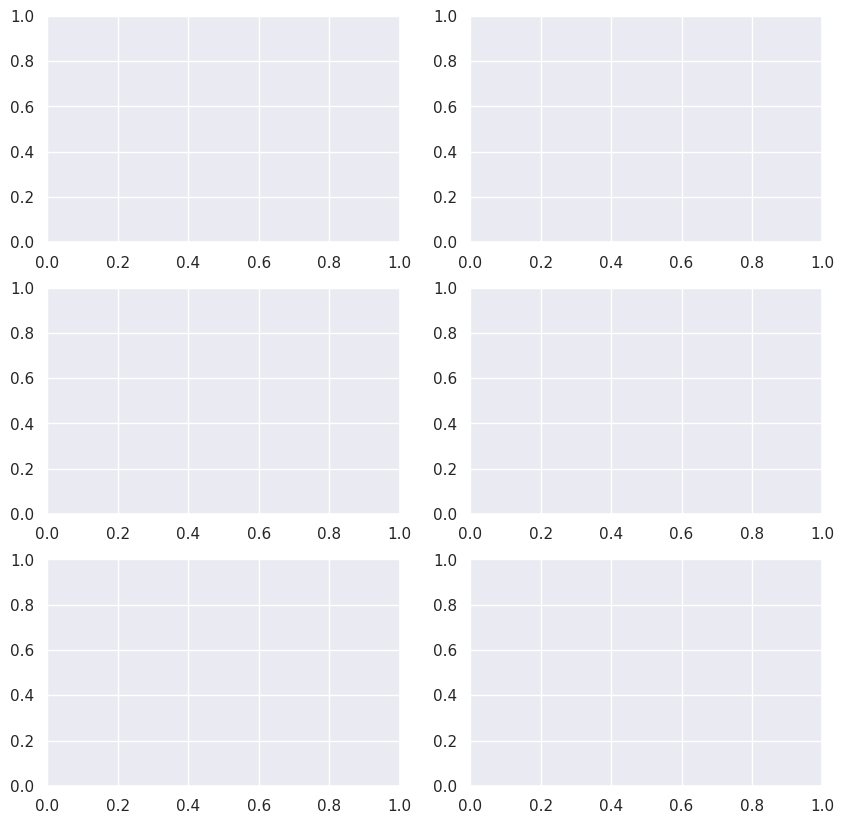

In [10]:
plt.subplots(3, 2, figsize = (10, 10))
for i, name in enumerate( ):
    plt.subplot(3, 2, i+1)
    for dataset_id, group_data in metrics.groupby('dataset_id'):
        plt.plot(group_data['layer'], np.clip(group_data[name], -0.05, 1), label=f'model {dataset_id}', marker='.', linestyle='-')
    plt.xlabel('Layer')
    plt.ylabel(name)
    plt.title(name)
    plt.legend()
plt.tight_layout()

### Evaluate Results

In [118]:
from sklearn.impute import SimpleImputer

tqdm_pbar = lambda x, y: tqdm(x, leave=True, position=0, total=len(x), desc=f'{y}')
def get_cls_embeddings_for_dataset(dataset_name, dataset, 
                                   feature_names, model, tokenizer, 
                                   pbar_func=tqdm_pbar, device=device, CUT_SIZE=CUT_SIZE):
    collected_embeddings = defaultdict(list)

    for split, data in dataset.items():
        
        # pbar = pbar_func(data, f"{split} {dataset_name}") if pbar_func is not None else data
        for example in data:
            # Encode the input sentences
            if len(feature_names) == 2:
                encoded_inputs = tokenizer.encode(
                    example[feature_names[0]], 
                    example[feature_names[1]], 
                    truncation=True, 
                    return_tensors='pt'
                )
            else:
                encoded_inputs = tokenizer.encode(*list(map(lambda x: example[x] , feature_names)), 
                                              truncation=True, 
                                              return_tensors='pt')
            
            special_token_positions = (encoded_inputs[0] < 103).nonzero().squeeze()
            encoded_inputs = encoded_inputs.to(device)

            # print(f"Encoded inputs: {encoded_inputs}")
            # print(f"Special token positions: {special_token_positions}")
            
            # Forward pass through the model
            with torch.no_grad():
                outputs = model(encoded_inputs)
            # print(f'Outputs: {outputs}')

            # Get the embedding of the [CLS] token
            cls_embedding = outputs.last_hidden_state[:, 0, :]

            # Append the [CLS] embedding to the list
            collected_embeddings[split].append(cls_embedding)
         
    return collected_embeddings

def train_linear(X_train, y_train):
    classifier = LogisticRegression(solver='lbfgs', max_iter=3000)
    classifier.fit(X_train, y_train)
    return classifier

def evaluate_classifier(classifier, X, y=None):
    predictions = classifier.predict(X)
    return predictions

def get_metrics_report(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred,  average='weighted')
    print('Weighted F1', f1)
    print('Accuracy', accuracy)
    print('-------------------------------')
    return f1, accuracy

glue_classification = {'mrpc': ['sentence1', 'sentence2'], 'sst2':  ['sentence']}
superglue_classification = {'wic': ['sentence1', 'sentence2']}
all_classification = {'glue': glue_classification, 'superglue': superglue_classification}

glue_datasets = load_datasets('glue', list(glue_classification), 200)
superglue_datasets = load_datasets('super_glue', list(superglue_classification), 200)

all_datasets = {'glue': glue_datasets, 'superglue': superglue_datasets}

results = pd.DataFrame([])

def get_layer_results(initial_model):
    initial_model = initial_model.to(device)
    for layer in range(11):
        layers = list(range(layer, 11))
        coefs = [final_coefs[i] for i in layers]
        if model == 'bert':
            custom_model = BertWrapperLin(initial_model, LinearClassifierBertAttention, coefs, layers).to(device)
        else: 
            custom_model = GPT2WrapperLin(initial_model, LinearClassifierGPT2Attention, coefs,
                            layers).to(device)
        
    

def check_results(custom_model, initial_model):
    data = {}
    for dn, datasets in all_datasets.items():
        for dataset_name, dataset in datasets.items():
            print(f"{dn.upper()} / {dataset_name}\n")
            
            print('Original')
            dataset_embeddings_orig = get_cls_embeddings_for_dataset(
                dataset_name,
                dataset, 
                all_classification[dn][dataset_name], 
                initial_model, 
                tokenizer)
            
            train_dataset_embeddings = torch.cat(dataset_embeddings_orig['train'], dim=0)
            valid_dataset_embeddings = torch.cat(dataset_embeddings_orig['validation'], dim=0)
            test_dataset_embeddings = torch.cat(dataset_embeddings_orig['test'], dim=0)
            
            classif = train_linear(train_dataset_embeddings.cpu(), [el['label'] for el in dataset['train']])
            valid_preds = evaluate_classifier(classif, valid_dataset_embeddings.cpu())
            print('Validation evaluation:\n')
            get_metrics_report([el['label'] for el in dataset['validation']], valid_preds)
            
            
            
            print('Linear:')
            
            dataset_embeddings_custom = get_cls_embeddings_for_dataset(
                dataset_name,
                dataset, 
                all_classification[dn][dataset_name], 
                custom_model, 
                tokenizer)
            
            train_dataset_embeddings = torch.cat(dataset_embeddings_custom['train'], dim=0)
            valid_dataset_embeddings = torch.cat(dataset_embeddings_custom['validation'], dim=0)
            test_dataset_embeddings = torch.cat(dataset_embeddings_custom['test'], dim=0)


            classif = train_linear(train_dataset_embeddings.cpu(), [el['label'] for el in dataset['train']])
            valid_preds = evaluate_classifier(classif, valid_dataset_embeddings.cpu())
            print('Validation evaluation:\n')
            f1, acc = get_metrics_report([el['label'] for el in dataset['validation']], valid_preds)
            print('-------------------------------')    


In [107]:
initial_model = initial_model.to(device)
if model == 'bert':
    custom_model = BertWrapperLin(initial_model, LinearClassifierBertAttention, final_coefs, list(final_coefs.keys())).to(device)
else: 
    custom_model = GPT2WrapperLin(initial_model, LinearClassifierGPT2Attention, linear_layers,
                        list(linear_layers.keys())).to(device)
check_results(custom_model, initial_model)

GLUE / mrpc

Original
Validation evaluation:

Weighted F1 0.6956793959319341
Accuracy 0.735
-------------------------------
Linear:
Validation evaluation:

Weighted F1 0.5900000000000002
Accuracy 0.675
-------------------------------
-------------------------------
GLUE / sst2

Original
Validation evaluation:

Weighted F1 0.7950051251281284
Accuracy 0.795
-------------------------------
Linear:
Validation evaluation:

Weighted F1 0.5442824960576707
Accuracy 0.545
-------------------------------
-------------------------------
SUPERGLUE / wic

Original
Validation evaluation:

Weighted F1 0.5980676328502416
Accuracy 0.6
-------------------------------
Linear:
Validation evaluation:

Weighted F1 0.5631954745443117
Accuracy 0.565
-------------------------------
-------------------------------


In [129]:
custom_model = BertWrapperLin(initial_model, LinearClassifierBertAttention, final_coefs, list(range(5, 12))).to(device)
# else: 
#     custom_model = GPT2WrapperLin(initial_model, LinearClassifierGPT2Attention, linear_layers,
                        # list(linear_layers.keys())).to(device)
check_results(custom_model, initial_model)

GLUE / mrpc

Original
Validation evaluation:

Weighted F1 0.6956793959319341
Accuracy 0.735
-------------------------------
Linear:
Validation evaluation:

Weighted F1 0.6152307692307692
Accuracy 0.695
-------------------------------
-------------------------------
GLUE / sst2

Original
Validation evaluation:

Weighted F1 0.7950051251281284
Accuracy 0.795
-------------------------------
Linear:
Validation evaluation:

Weighted F1 0.6641691926150455
Accuracy 0.665
-------------------------------
-------------------------------
SUPERGLUE / wic

Original
Validation evaluation:

Weighted F1 0.5980676328502416
Accuracy 0.6
-------------------------------
Linear:
Validation evaluation:

Weighted F1 0.495959595959596
Accuracy 0.5
-------------------------------
-------------------------------


In [197]:
custom_model = BertWrapperLin(initial_model, LinearClassifierBertAttention, final_coefs, list(range(6, 12))).to(device)
# else: 
#     custom_model = GPT2WrapperLin(initial_model, LinearClassifierGPT2Attention, linear_layers,
                        # list(linear_layers.keys())).to(device)
check_results(custom_model, initial_model)

GLUE / mrpc

Original
Validation evaluation:

Weighted F1 0.6956793959319341
Accuracy 0.735
-------------------------------
Linear:
Validation evaluation:

Weighted F1 0.6460428706525165
Accuracy 0.685
-------------------------------
-------------------------------
GLUE / sst2

Original
Validation evaluation:

Weighted F1 0.7950051251281284
Accuracy 0.795
-------------------------------
Linear:
Validation evaluation:

Weighted F1 0.754121467439003
Accuracy 0.755
-------------------------------
-------------------------------
SUPERGLUE / wic

Original
Validation evaluation:

Weighted F1 0.5980676328502416
Accuracy 0.6
-------------------------------
Linear:
Validation evaluation:

Weighted F1 0.5550333825110649
Accuracy 0.555
-------------------------------
-------------------------------


In [131]:
custom_model = BertWrapperLin(initial_model, LinearClassifierBertAttention, final_coefs, list(range(10, 12))).to(device)
# else: 
#     custom_model = GPT2WrapperLin(initial_model, LinearClassifierGPT2Attention, linear_layers,
                        # list(linear_layers.keys())).to(device)
check_results(custom_model, initial_model)

GLUE / mrpc

Original
Validation evaluation:

Weighted F1 0.6956793959319341
Accuracy 0.735
-------------------------------
Linear:
Validation evaluation:

Weighted F1 0.6650466200466201
Accuracy 0.71
-------------------------------
-------------------------------
GLUE / sst2

Original
Validation evaluation:

Weighted F1 0.7950051251281284
Accuracy 0.795
-------------------------------
Linear:
Validation evaluation:

Weighted F1 0.8049268585431721
Accuracy 0.805
-------------------------------
-------------------------------
SUPERGLUE / wic

Original
Validation evaluation:

Weighted F1 0.5980676328502416
Accuracy 0.6
-------------------------------
Linear:
Validation evaluation:

Weighted F1 0.5344758135223827
Accuracy 0.535
-------------------------------
-------------------------------


In [202]:
import time
rte = load_dataset('glue', 'qnli')
long_dataset = []
cols = ['question', 'sentence']
for i in rte['train']:
    if sum([len(i[t]) for t in cols]) > 900:
        long_dataset.append(i)
for i in rte['test']:
    if sum([len(i[t]) for t in cols]) > 900:
        long_dataset.append(i)
for i in rte['validation']:
    if sum([len(i[t]) for t in cols]) > 900:
        long_dataset.append(i)

l = round(len(long_dataset)*0.9)
print(f'Dataset size: {len(long_dataset)}') 
l_d = {'train': long_dataset[:l], 'validation':long_dataset[l:]}
print('Original:')
start_time = time.time()
dataset_embeddings_orig = get_cls_embeddings_for_dataset(
                'long_dataset',
                l_d, 
                cols, 
                initial_model, 
                tokenizer)

print(f'Original time: {time.time()- start_time }')

train_dataset_embeddings = torch.cat(dataset_embeddings_orig['train'], dim=0)
valid_dataset_embeddings = torch.cat(dataset_embeddings_orig['validation'], dim=0)
            
classif = train_linear(train_dataset_embeddings.cpu(), [el['label'] for el in l_d['train']])
valid_preds = evaluate_classifier(classif, valid_dataset_embeddings.cpu())
print('Validation evaluation:\n')
get_metrics_report([el['label'] for el in l_d['validation']], valid_preds)
            # print(train_dataset_embeddings.shape)

            
print('Linear:')
start_time = time.time()    
dataset_embeddings_custom = get_cls_embeddings_for_dataset(
                'long_dataset',
                l_d, 
                cols, 
                custom_model, 
                tokenizer)
print(f'Original time: {time.time()- start_time }')
            
train_dataset_embeddings = torch.cat(dataset_embeddings_custom['train'], dim=0)
valid_dataset_embeddings = torch.cat(dataset_embeddings_custom['validation'], dim=0)


classif = train_linear(train_dataset_embeddings.cpu(), [el['label'] for el in l_d['train']])
valid_preds = evaluate_classifier(classif, valid_dataset_embeddings.cpu())
print('Validation evaluation:\n')
get_metrics_report([el['label'] for el in l_d['validation']], valid_preds)
print('-------------------------------')

Dataset size: 30
Original:
Original time: 4.594026327133179
Validation evaluation:

Weighted F1 0.16666666666666666
Accuracy 0.3333333333333333
-------------------------------
Linear:
Original time: 4.907689571380615
Validation evaluation:

Weighted F1 0.16666666666666666
Accuracy 0.3333333333333333
-------------------------------
-------------------------------


In [ ]:
llangnickel
/
long-covid-classification-data 

In [217]:
data = load_dataset('THUDM/LongBench', "trec_e")

Generating test split: 0 examples [00:00, ? examples/s]

In [220]:
long_data_1 = load_dataset('llangnickel/long-covid-classification-data')
long_data_2 = load_dataset('THUDM/LongBench', "trec_e")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [224]:
l = 0
for i in data['train']:
    l+=len(i['text'])
print(l/len(data['train']))

1620.306763285024
